In [1]:
!nvidia-smi

Sat Aug  4 16:08:16 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.37                 Driver Version: 396.37                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:05:00.0 Off |                  Off |
| N/A   37C    P0    28W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:84:00.0 Off |                  Off |
| N/A   36C    P0    26W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import time
import tensorflow as tf
import keras
from keras.layers import CuDNNLSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy.random as rand

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
filename = 'TrainEOB_q-1-10-0.02_ProperWhitenZ.h5'
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])
y_train = data

filename = 'TestEOB_q-1-10-0.02_ProperWhitenZ.h5'
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])
y_test = data

print("Number of Training Waves: " + str(len(y_train)))
print("Number of Testing Waves: " + str(len(y_test)))

Number of Training Waves: 9861
Number of Testing Waves: 2459


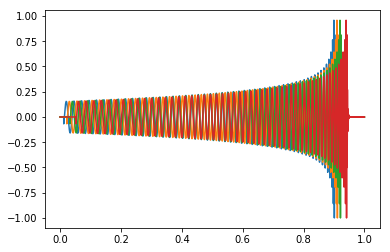

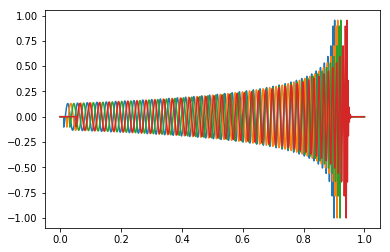

In [4]:
# Shift waves

t = np.linspace(0, 1, 8192)

shift_1 = int(8192 * 0.99)
shift_2 = int(8192 * 0.98)
shift_3 = int(8192 * 0.96)

y_train_1 = []
y_train_2 = []
y_train_3 = []
for i in range(len(y_train)):
    wave_1 = y_train[i][:shift_1]
    wave_1 = np.concatenate((np.zeros(8192 - shift_1), wave_1), axis=0)
    y_train_1.append(wave_1)
    wave_2 = y_train[i][:shift_2]
    wave_2 = np.concatenate((np.zeros(8192 - shift_2), wave_2), axis=0)
    y_train_2.append(wave_2)
    wave_3 = y_train[i][:shift_3]
    wave_3 = np.concatenate((np.zeros(8192 - shift_3), wave_3), axis=0)
    y_train_3.append(wave_3)
    
plt.plot(t, y_train[32])
plt.plot(t, y_train_1[32])
plt.plot(t, y_train_2[32])
plt.plot(t, y_train_3[32])
plt.show()

y_test_1 = []
y_test_2 = []
y_test_3 = []
for i in range(len(y_test)):
    wave_1 = y_test[i][:shift_1]
    wave_1 = np.concatenate((np.zeros(8192 - shift_1), wave_1), axis=0)
    y_test_1.append(wave_1)
    wave_2 = y_test[i][:shift_2]
    wave_2 = np.concatenate((np.zeros(8192 - shift_2), wave_2), axis=0)
    y_test_2.append(wave_2)
    wave_3 = y_test[i][:shift_3]
    wave_3 = np.concatenate((np.zeros(8192 - shift_3), wave_3), axis=0)
    y_test_3.append(wave_3)
    
plt.plot(t, y_test[32])
plt.plot(t, y_test_1[32])
plt.plot(t, y_test_2[32])
plt.plot(t, y_test_3[32])
plt.show()

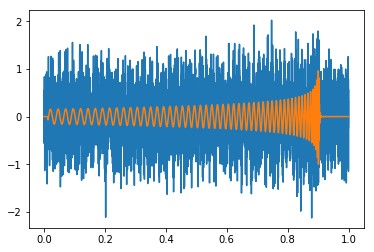

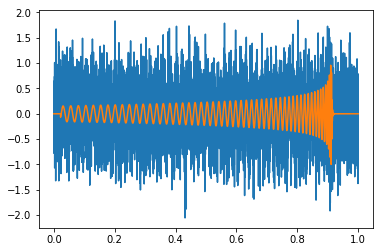

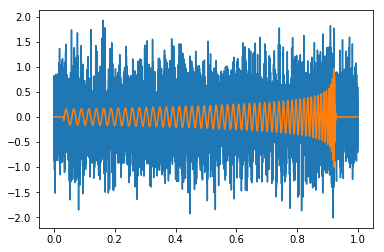

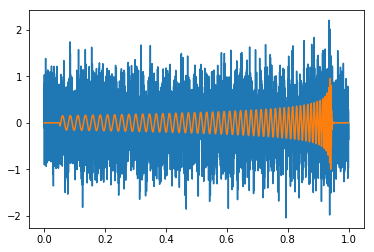

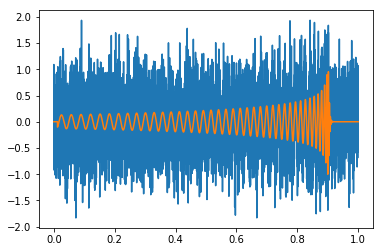

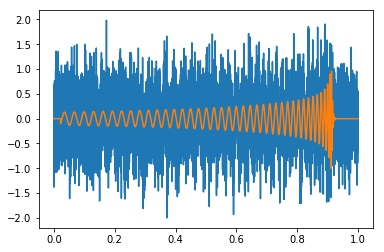

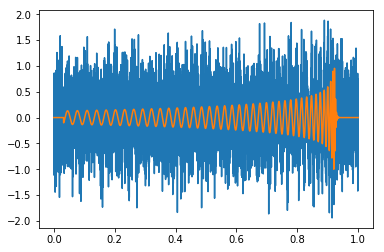

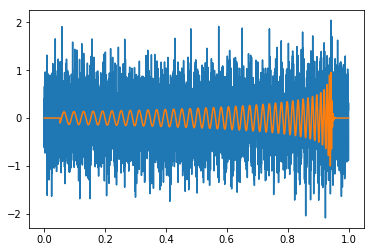

In [5]:
# Add noise

# snr_1 = 1
# snr_2 = 0.9
# snr_3 = 0.8
# snr_4 = 0.7

snr_1 = 2
snr_2 = 2
snr_3 = 2
snr_4 = 2

x_train = []
x_train_1 = []
x_train_2 = []
x_train_3 = []
for i in range(len(y_train)):
    
    noise_1 = (1 / snr_1) * np.random.normal(0,1,8192)
    noise_2 = (1 / snr_2) * np.random.normal(0,1,8192)
    noise_3 = (1 / snr_3) * np.random.normal(0,1,8192)
    noise_4 = (1 / snr_4) * np.random.normal(0,1,8192)
    
    x_train.append(y_train[i] + noise_1)
    x_train_1.append(y_train_1[i] + noise_2)
    x_train_2.append(y_train_2[i] + noise_3)
    x_train_3.append(y_train_3[i] + noise_4)
    
plt.plot(t, x_train[32])
plt.plot(t, y_train[32])
plt.show()
plt.plot(t, x_train_1[32])
plt.plot(t, y_train_1[32])
plt.show()
plt.plot(t, x_train_2[32])
plt.plot(t, y_train_2[32])
plt.show()
plt.plot(t, x_train_3[32])
plt.plot(t, y_train_3[32])
plt.show()
    
x_test = []
x_test_1 = []
x_test_2 = []
x_test_3 = []
for i in range(len(y_test)):
    
    noise_1 = (1 / snr_1) * np.random.normal(0,1,8192)
    noise_2 = (1 / snr_2) * np.random.normal(0,1,8192)
    noise_3 = (1 / snr_3) * np.random.normal(0,1,8192)
    noise_4 = (1 / snr_4) * np.random.normal(0,1,8192)
    
    x_test.append(y_test[i] + noise_1)
    x_test_1.append(y_test_1[i] + noise_2)
    x_test_2.append(y_test_2[i] + noise_3)
    x_test_3.append(y_test_3[i] + noise_4)
    
plt.plot(t, x_test[32])
plt.plot(t, y_test[32])
plt.show()
plt.plot(t, x_test_1[32])
plt.plot(t, y_test_1[32])
plt.show()
plt.plot(t, x_test_2[32])
plt.plot(t, y_test_2[32])
plt.show()
plt.plot(t, x_test_3[32])
plt.plot(t, y_test_3[32])
plt.show()

In [6]:
# Reshape x_train to have a shape of (9861, 8192, 4)
x_train = np.squeeze(x_train)
x_train_1 = np.squeeze(x_train_1)
x_train_2 = np.squeeze(x_train_2)
x_train_3 = np.squeeze(x_train_3)

x_train = np.array(x_train)
x_train_1 = np.array(x_train_1)
x_train_2 = np.array(x_train_2)
x_train_3 = np.array(x_train_3)

x_train = np.expand_dims(x_train, axis=-1)
x_train_1 = np.expand_dims(x_train_1, axis=-1)
x_train_2 = np.expand_dims(x_train_2, axis=-1)
x_train_3 = np.expand_dims(x_train_3, axis=-1)

x_train = np.concatenate((x_train, x_train_1, x_train_2, x_train_3), axis=-1)

# Reshape x_test to have a shape of (2459, 8192, 4)

x_test = np.squeeze(x_test)
x_test_1 = np.squeeze(x_test_1)
x_test_2 = np.squeeze(x_test_2)
x_test_3 = np.squeeze(x_test_3)

x_test = np.array(x_test)
x_test_1 = np.array(x_test_1)
x_test_2 = np.array(x_test_2)
x_test_3 = np.array(x_test_3)

x_test = np.expand_dims(x_test, axis=-1)
x_test_1 = np.expand_dims(x_test_1, axis=-1)
x_test_2 = np.expand_dims(x_test_2, axis=-1)
x_test_3 = np.expand_dims(x_test_3, axis=-1)

x_test = np.concatenate((x_test, x_test_1, x_test_2, x_test_3), axis=-1)

print(x_train.shape)
print(x_test.shape)

# Convert y_train and y_test to NumPy Arrays (from Python Lists)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train.shape)
print(y_test.shape)

(9861, 8192, 4)
(2459, 8192, 4)
(9861, 8192)
(2459, 8192)


In [7]:
y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)
print(y_train.shape)
print(y_test.shape)

(9861, 8192, 1)
(2459, 8192, 1)


In [8]:
def get_batch(size, train=True):
    
    x = []
    y = []
    
    for i in range(size):
        
        if train == True:
            k = rand.randint(0, 9861)
            x.append(x_train[k])
            y.append(y_train[k])
        else:
            k = rand.randint(0, 2459)
            x.append(x_test[k])
            y.append(y_test[k])
        
    x = np.array(x)
    y = np.array(y)
        
    return x, y

In [9]:
# Try LSTM, GRU, hyperparameters
# decrease SNR when loss is constant

# hidden_units = [32, 64, 128, 256, 512]       # 2.1 Million       # newest weights file is #9
# hidden_units = [128, 256, 512, 256, 128]     # 3.0 Million       # newest weights file is #11
hidden_units = [512, 256, 128, 64, 32]       # 2.1 Million

model = Sequential()

model.add(LSTM(return_sequences=True, input_shape=(8192, 4), units=hidden_units[0]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[0]), units=hidden_units[1]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[1]), units=hidden_units[2]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[2]), units=hidden_units[3]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[3]), units=hidden_units[4]))
model.add(LSTM(return_sequences=True, input_shape=(8192, hidden_units[4]), units=1))

optimizer = keras.optimizers.RMSprop(lr=0.0005)
model.compile(loss="mse", optimizer=optimizer)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8192, 512)         1058816   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8192, 256)         787456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8192, 128)         197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8192, 64)          49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 8192, 32)          12416     
_________________________________________________________________
lstm_6 (LSTM)                (None, 8192, 1)           136       
Total params: 2,105,352
Trainable params: 2,105,352
Non-trainable params: 0
_________________________________________________________________


In [10]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

Epoch 1/1
50/50 [==============================] - 3427s 69s/step - loss: 0.0146
Loss History:


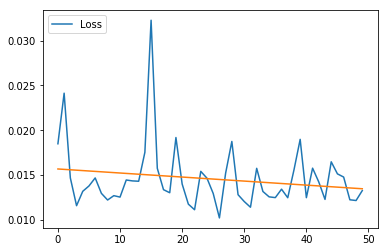

 
Training duration (min) :  57.17854441801707
Weights saved.
Epoch 1/1
50/50 [==============================] - 3579s 72s/step - loss: 0.0131
Loss History:


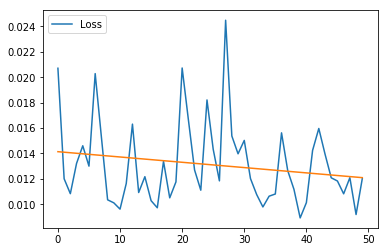

 
Training duration (min) :  116.83374795516332
Weights saved.
Epoch 1/1
50/50 [==============================] - 3570s 71s/step - loss: 0.0115
Loss History:


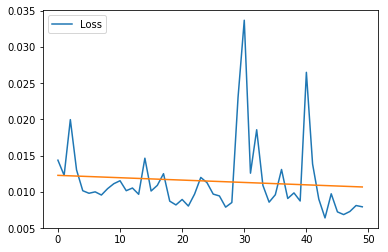

 
Training duration (min) :  176.34348758459092
Weights saved.
Epoch 1/1
50/50 [==============================] - 3603s 72s/step - loss: 0.0084
Loss History:


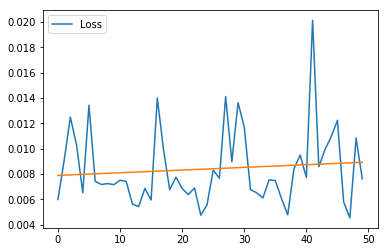

 
Training duration (min) :  236.39304600159326
Weights saved.
Epoch 1/1
50/50 [==============================] - 3590s 72s/step - loss: 0.0085
Loss History:


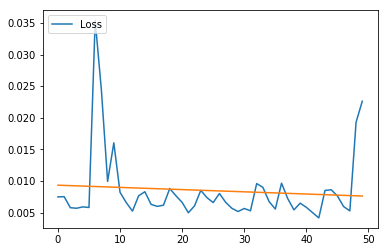

 
Training duration (min) :  296.224189778169
Weights saved.
Epoch 1/1
50/50 [==============================] - 3574s 71s/step - loss: 0.0064
Loss History:


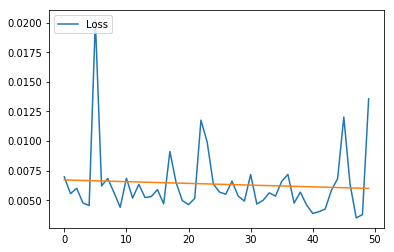

 
Training duration (min) :  355.7929537812869
Weights saved.
Epoch 1/1
50/50 [==============================] - 3581s 72s/step - loss: 0.0067
Loss History:


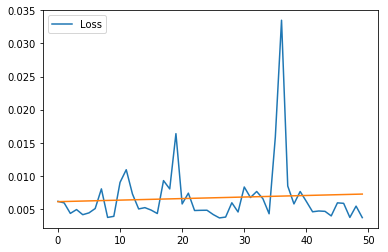

 
Training duration (min) :  415.47397436698276
Weights saved.
Epoch 1/1
50/50 [==============================] - 3579s 72s/step - loss: 0.0061
Loss History:


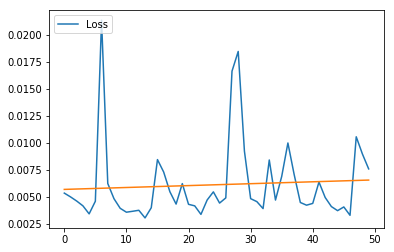

 
Training duration (min) :  475.1312865138054
Weights saved.
Epoch 1/1
50/50 [==============================] - 3568s 71s/step - loss: 0.0059
Loss History:


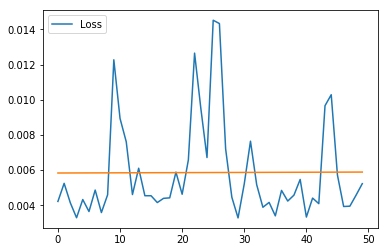

 
Training duration (min) :  534.6089162230492
Weights saved.
Epoch 1/1
50/50 [==============================] - 3575s 71s/step - loss: 0.0052
Loss History:


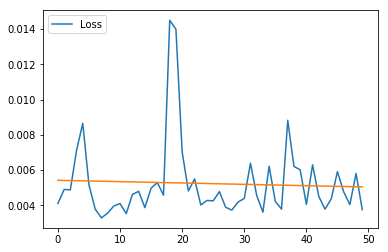

 
Training duration (min) :  594.1966779987017
Weights saved.


In [11]:
global_start_time = time.time()

# model.load_weights('rnn_weights_17.h5')

for j in range(10):
    
    x_train_batch, y_train_batch = get_batch(50)
    history = LossHistory()
    model.fit(x_train_batch,
              y_train_batch,
              batch_size=1,
              epochs=1,
              callbacks=[history])
    
    loss = np.array(history.losses)
    coefficients = np.polyfit(np.linspace(0, 1, num=loss.size), loss, 1)
    trendline = coefficients[0]*(np.linspace(0, 1, num=loss.size)) + coefficients[1]
    
    print("Loss History:")
    plt.plot(loss, label = 'Loss')
    plt.legend(loc='upper left')
    plt.plot(trendline)
    plt.show()

    print(" ")
    print('Training duration (min) : ', (time.time() - global_start_time)/60)
    
    # num = 8 + j
    model.save_weights("rnn_weights_2" + str(j) + ".h5")

    print("Weights saved.")
    

In [12]:
x_test_batch, y_test_batch = get_batch(50, train=False)
predicted = model.predict(x_test_batch)

Average MSE:  3391.211111459503


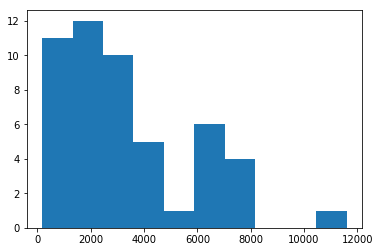

 
Total number of test waves: 50
Number of waves with MSE < 0.5: 0
Number of waves with MSE > 100: 50


In [13]:
avg_mse = 0
count_1 = 0
count_2 = 0
mse = []
for i in range(len(y_test_batch)):
    avg_mse += np.square(np.sum(y_test_batch[i] - predicted[i]))
    mse.append(np.square(np.sum(y_test_batch[i] - predicted[i])))
    if np.square(np.sum(y_test_batch[i] - predicted[i])) > 100:
        count_2 += 1
    elif np.square(np.sum(y_test_batch[i] - predicted[i])) < 0.5:
        count_1 += 1
    
print("Average MSE: ", avg_mse / len(y_test_batch))
plt.hist(mse)
plt.show()
print(" ")
print("Total number of test waves: " + str(len(x_test_batch)))
print("Number of waves with MSE < 0.5: " + str(count_1))
print("Number of waves with MSE > 100: " + str(count_2))

A Sample of the Results:
MSE:  1105.7472830587694


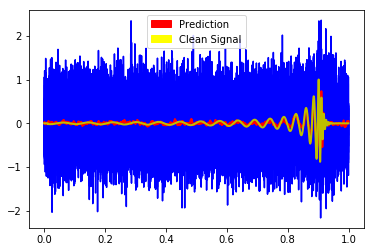

MSE:  775.2617217832169


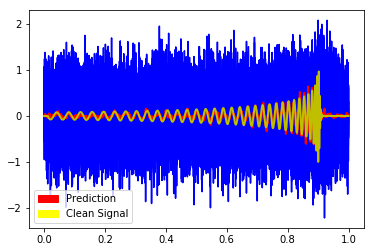

MSE:  1707.4582833259212


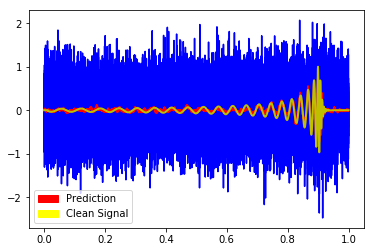

MSE:  3870.6266612593845


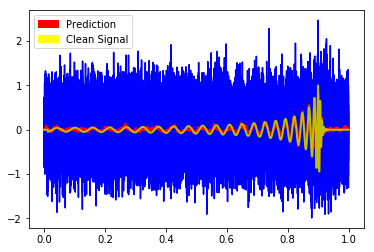

MSE:  3612.5441211974135


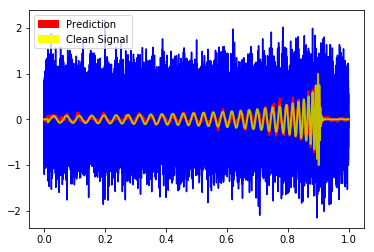

In [14]:
print("A Sample of the Results:")

indices = [3, 4, 6, 7, 13]

for n in indices:
    print("MSE: ", np.square(np.sum(y_test_batch[n] - predicted[n])))
    plt.plot(t, x_test_batch[n], "b-", label='Noisy Signal')
    plt.plot(t, predicted[n], "r-", label='Prediction', linewidth=2.0)
    plt.plot(t, y_test_batch[n], "y-", label='True Data', linewidth=2.0)
    red_patch = mpatches.Patch(color='red', label='Prediction')
    yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
    plt.legend(handles=[red_patch, yellow_patch])
    plt.show()